## LIBS

In [1]:
import pandas as pd
import os
import numpy as np
import yaml
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lazypredict
from lazypredict.Supervised import LazyRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from yellowbrick.regressor import ResidualsPlot


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
random.seed(42) 
config_path = os.path.join(os.getcwd(), 'config\config.yaml')

In [2]:
import pandas as pd
import os
import numpy as np
import yaml
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lazypredict
from lazypredict.Supervised import LazyRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from yellowbrick.regressor import ResidualsPlot

In [3]:
with open(config_path) as f:
    config = yaml.safe_load(f)

In [4]:
df = pd.read_csv(os.path.join(config['SavePath'], config['files'] + ".csv"))
df.shape

(12513, 52)

## TARGET VARIABLE 

In [5]:
def convert_to_euro(price):
    price = price.replace("\u2009", "").replace("\t", "").replace(",", "")
    if pd.isnull(price):
        return np.nan
    if price.startswith("About"):
        price = float(price.split(" ")[1]) + round(random.uniform(0, 9), 2)
    else:
        euro_tag = [p for p in price.split("/") if "€" in p]
        if len(euro_tag) > 0:
            price = float(euro_tag[0].split("€")[1])
        else:
            currency_tag = []
            for c in config['conversion_rates'].keys():
                if c in price:
                    currency_tag.append(c)
            if currency_tag:
                number = float(re.findall("\d+", price.split(currency_tag[0])[1])[0])
                price = config['conversion_rates'][currency_tag[0]] * number 
    return price

In [6]:
df = df[~df['MISC_Price'].str.contains('BTC', na=False)]
# df = df.dropna(subset=['MISC_Price'])
df = df.reset_index(drop=True)
df.shape

(12512, 52)

In [7]:
df_na = df[df['MISC_Price'].isna()]
df = df.dropna(subset=['MISC_Price'])
df.shape

(8438, 52)

In [8]:
df['MISC_Price_Euro'] = df['MISC_Price'].apply(convert_to_euro)

In [9]:
df[['Name','MISC_Price', 'MISC_Price_Euro']].head(10)

,Name,MISC_Price,MISC_Price_Euro
0,Acer Chromebook Tab 10,About 330 EUR,335.75
1,Acer Iconia Talk S,About 170 EUR,170.23
2,Acer Liquid Z6 Plus,About 250 EUR,252.48
3,Acer Liquid Z6,About 120 EUR,122.01
4,Acer Iconia Tab 10 A3-A40,About 230 EUR,236.63
5,Acer Liquid X2,About 230 EUR,236.09
7,Acer Liquid Zest Plus,About 200 EUR,208.03
8,Acer Liquid Zest,About 110 EUR,110.78
9,Acer Predator 8,About 350 EUR,353.80
10,Acer Liquid Jade Primo,About 220 EUR,220.27


## Other variables

In [10]:
df.info(
    null_counts=True
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8438 entries, 0 to 12493
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Brand                  8438 non-null   object 
 1   url                    8438 non-null   object 
 2   imgUrl                 8438 non-null   object 
 3   Name                   8438 non-null   object 
 4   NETWORK_Technology     8438 non-null   object 
 5   NETWORK_2G_bands       8438 non-null   object 
 6   NETWORK_3G_bands       6874 non-null   object 
 7   NETWORK_4G_bands       4609 non-null   object 
 8   NETWORK_5G_bands       1045 non-null   object 
 9   NETWORK_GPRS           1837 non-null   object 
 10  NETWORK_EDGE           1829 non-null   object 
 11  NETWORK_Speed          6843 non-null   object 
 12  LAUNCH_Announced       8436 non-null   object 
 13  LAUNCH_Status          8438 non-null   object 
 14  BODY_Dimensions        8434 non-null   object 
 15  BOD

In [11]:
df.drop(['MISC_Price'], axis=1, inplace=True)

### Brand, url and Name

In [12]:
# #label encoding for Brand, drop url, imgUrl, Name
# from sklearn.preprocessing import LabelEncoder
# enc_brand = LabelEncoder()
# df['Brand'] = enc_brand.fit_transform(df['Brand'])
# df = df.drop(['url', 'imgUrl', 'Name'], axis=1)

#### Người ta bảo `brand` hay bị giá ảo -> test liền `target encoding`
- Phương pháp này giúp encode các biến category thành mean của target tương ứng với category đó
- Có thể dùng `smoothing` để tránh overfitting

In [13]:
from sklearn.preprocessing import TargetEncoder
enc_brand = TargetEncoder()
df['Brand'] = enc_brand.fit_transform(np.array(df['Brand']).reshape(-1, 1), df['MISC_Price_Euro'])
df_na['Brand'] = enc_brand.transform(np.array(df_na['Brand']).reshape(-1, 1))
df = df.drop(['url', 'imgUrl', 'Name'], axis=1)
df_na = df_na.drop(['url', 'imgUrl', 'Name'], axis=1)

### Network_2345G

In [14]:
df[['NETWORK_2G_bands', 'NETWORK_3G_bands', 'NETWORK_4G_bands', 'NETWORK_5G_bands']].head(10)

,NETWORK_2G_bands,NETWORK_3G_bands,NETWORK_4G_bands,NETWORK_5G_bands
0,N/A,NaN,NaN,NaN
1,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,HSDPA 850 / 1900 / 2100,"1, 3, 7, 8, 20",NaN
2,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (dual-SIM model only),HSDPA,LTE (unspecified),NaN
3,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (dual-SIM model only),HSDPA,LTE (unspecified),NaN
4,N/A,NaN,NaN,NaN
5,GSM 850 / 900 / 1800 / 1900,"HSDPA 900 / 1900 / 2100 - Europe, Taiwan",LTE 800 / 1800 / 2100 / 2600 - Europe,NaN
7,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (dual-SIM model only),HSDPA,LTE (unspecified),NaN
8,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (dual-SIM model only),HSDPA 850 / 900 / 1900 / 2100,LTE (unspecified),NaN
9,N/A,NaN,NaN,NaN
10,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,HSDPA 850 / 900 / 1900 / 2100 - Europe/ Taiwan,LTE 800 / 1800 / 2100 / 2600 - Europe,NaN


In [15]:
print("2G number of unique values: ", df['NETWORK_2G_bands'].nunique())
print("3G number of unique values: ", df['NETWORK_3G_bands'].nunique())
print("4G number of unique values: ", df['NETWORK_4G_bands'].nunique())
print("5G number of unique values: ", df['NETWORK_5G_bands'].nunique())

2G number of unique values:  199
3G number of unique values:  588
4G number of unique values:  1458
5G number of unique values:  402


#### Target Encoding 

In [16]:
from category_encoders import TargetEncoder
enc_network = TargetEncoder()
df[['NETWORK_2G_bands', 'NETWORK_3G_bands', 'NETWORK_4G_bands', 'NETWORK_5G_bands']] = enc_network.fit_transform(df[['NETWORK_2G_bands', 'NETWORK_3G_bands', 'NETWORK_4G_bands', 'NETWORK_5G_bands']], df['MISC_Price_Euro'])
df_na[['NETWORK_2G_bands', 'NETWORK_3G_bands', 'NETWORK_4G_bands', 'NETWORK_5G_bands']] = enc_network.transform(df_na[['NETWORK_2G_bands', 'NETWORK_3G_bands', 'NETWORK_4G_bands', 'NETWORK_5G_bands']]) 

In [17]:
df[['NETWORK_2G_bands', 'NETWORK_3G_bands', 'NETWORK_4G_bands', 'NETWORK_5G_bands']].head(10)

,NETWORK_2G_bands,NETWORK_3G_bands,NETWORK_4G_bands,NETWORK_5G_bands
0,302.11,140.86,157.74,307.45
1,473.71,203.31,172.10,307.45
2,264.91,483.19,517.84,307.45
3,264.91,483.19,517.84,307.45
4,302.11,140.86,157.74,307.45
5,236.17,312.89,310.73,307.45
7,264.91,483.19,517.84,307.45
8,264.91,375.86,517.84,307.45
9,302.11,140.86,157.74,307.45
10,473.71,310.83,310.73,307.45


### Network GPRS EDGE SPEED

In [18]:
df[['NETWORK_GPRS','NETWORK_EDGE']].head(10)

,NETWORK_GPRS,NETWORK_EDGE
0,No,No
1,NaN,NaN
2,Yes,Yes
3,Yes,Yes
4,No,No
5,NaN,NaN
7,Yes,Yes
8,NaN,NaN
9,No,No
10,NaN,NaN


In [19]:
df[['NETWORK_GPRS','NETWORK_EDGE']].nunique()

NETWORK_GPRS    21
NETWORK_EDGE    22
dtype: int64

In [20]:
#using same label encoding for GPRS and EDGE
from sklearn.preprocessing import LabelEncoder
enc_gprs = LabelEncoder()
df['NETWORK_GPRS'] = enc_gprs.fit_transform(df['NETWORK_GPRS'])
df['NETWORK_EDGE'] = enc_gprs.fit_transform(df['NETWORK_EDGE'])
# df_na['NETWORK_GPRS'] = enc_gprs.transform(df_na['NETWORK_GPRS'])
# df_na['NETWORK_EDGE'] = enc_gprs.transform(df_na['NETWORK_EDGE'])

In [21]:
df[['NETWORK_Speed', 'NETWORK_Technology']].head(10)

,NETWORK_Speed,NETWORK_Technology
0,NaN,No cellular connectivity
1,"HSPA 42.2/11.5 Mbps, LTE Cat4 150/50 Mbps",GSM / HSPA / LTE
2,"HSPA 42.2/5.76 Mbps, LTE Cat4 150/50 Mbps",GSM / HSPA / LTE
3,"HSPA, LTE",GSM / HSPA / LTE
4,NaN,No cellular connectivity
5,"HSPA 42.2/5.76 Mbps, LTE Cat4 150/50 Mbps",GSM / HSPA / LTE
7,"HSPA, LTE",GSM / HSPA / LTE
8,"HSPA, LTE Cat4 150/50 Mbps",GSM / HSPA / LTE
9,NaN,No cellular connectivity
10,"HSPA 42.2/5.76 Mbps, LTE-A (2CA) Cat6 300/50 Mbps",GSM / HSPA / LTE


In [22]:
df['NETWORK_Technology'].unique()

array(['No cellular connectivity', 'GSM / HSPA / LTE', 'GSM / HSPA',
       'GSM', 'GSM / UMTS', 'GSM / CDMA / HSPA / LTE', 'LTE',
       'CDMA / EVDO', 'GSM / HSPA / EVDO / LTE',
       'GSM / CDMA / HSPA / EVDO / LTE / 5G', 'GSM / HSPA / LTE / 5G',
       'GSM / CDMA / HSPA / EVDO / LTE', 'GSM / CDMA / HSPA / EVDO',
       'GSM / CDMA / HSPA / LTE / 5G', 'GSM / LTE', 'HSPA / LTE',
       'GSM / CDMA / EVDO', 'GSM / CDMA / HSPA / CDMA2000 / LTE / 5G',
       'GSM / CDMA / HSPA / CDMA2000 / LTE', 'GSM / CDMA',
       'GSM / HSPA / EVDO / LTE / 5G', 'LTE / 5G',
       'GSM / CDMA / EVDO / LTE', 'GSM / CDMA / HSPA',
       'CDMA / EVDO / LTE', 'CDMA / HSPA / EVDO / LTE',
       'GSM / UMTS / HSPA', 'GSM / HSPA / EVDO', 'CDMA / LTE',
       'CDMA / CDMA2000', 'CDMA', 'HSPA / EVDO', 'CDMA / HSPA',
       'CDMA / HSPA / EVDO', 'GSM / CDMA2000', 'GSM / UMTS / LTE',
       'CDMA / HSPA / LTE', 'GSM / UMTS / HSPA / LTE', 'HSPA',
       'GSM / CDMA / UMTS / EVDO', 'GSM / HSPA / CDMA2000',
     

In [23]:
df['NETWORK_Speed'].unique()

array([nan, 'HSPA 42.2/11.5 Mbps, LTE Cat4 150/50 Mbps',
       'HSPA 42.2/5.76 Mbps, LTE Cat4 150/50 Mbps', 'HSPA, LTE',
       'HSPA, LTE Cat4 150/50 Mbps',
       'HSPA 42.2/5.76 Mbps, LTE-A (2CA) Cat6 300/50 Mbps',
       'HSPA 42.2/5.76 Mbps', 'HSPA 21.1/5.76 Mbps, LTE Cat4 150/50 Mbps',
       'HSPA', 'HSPA 21.1/5.76 Mbps',
       'HSPA 42.2/5.76 Mbps, LTE-A Cat4 150/50 Mbps',
       'HSPA 7.2/5.76 Mbps', 'HSPA 7.2/0.384 Mbps', 'HSPA 14.4/5.76 Mbps',
       'HSPA 7.2/2 Mbps', 'TD-SCDMA', 'HSPA 14.4/2 Mbps',
       'HSPA 3.6/0.384 Mbps', 'HSPA 42.2/11.1 Mbps, LTE Cat4 150/50 Mbps',
       'LTE', 'No', 'HSPA 42.2/11.5 Mbps, LTE-A (2CA) Cat6 300/50 Mbps',
       'HSPA 42.2/5.76 Mbps, LTE Cat4 150/50 Mbps or LTE-A (2CA) Cat6 300/50 Mbps',
       'HSPA 21.1/5.76 Mbps, LTE', 'HSPA 42.2/11.5 Mbps',
       'HSPA 42.2/5.76 Mbps, LTE Cat3 100/50 Mbps',
       'HSPA 21.1/5.76 Mbps, LTE Cat3 100/50 Mbps',
       'EV-DO Rev.A 3.1 Mbps',
       'HSPA 42.2/11.5 Mbps, LTE Cat7 300/100 Mbps',
   

2 thằng sussy này có vẻ ảnh hưởng tới giá nhìu đó mấy ní => target encoding thui

In [24]:
#target encoding for NETWORK_Technology and NETWORK_Speed
enc_network_tech = TargetEncoder()
enc_network_speed = TargetEncoder()
df[['NETWORK_Technology']] = enc_network_tech.fit_transform(df[['NETWORK_Technology']], df['MISC_Price_Euro'])
df[['NETWORK_Speed']] = enc_network_speed.fit_transform(df[['NETWORK_Speed']], df['MISC_Price_Euro'])
df_na[['NETWORK_Technology']] = enc_network_tech.transform(df_na[['NETWORK_Technology']])
df_na[['NETWORK_Speed']] = enc_network_speed.transform(df_na[['NETWORK_Speed']])

### Launch annouced với status ko liên quan lắm (có liên quan thì có lẽ là kiểu dựa vào đó rồi train riêng theo từng thời kì, nhưng mà mình chưa biết làm thế nào để xử lý nên thôi) (bin categorize)

### Body dim, weight, build

In [25]:
df[['BODY_Dimensions','BODY_Weight', 'BODY_Build',]].head(10)

,BODY_Dimensions,BODY_Weight,BODY_Build
0,238.3 x 172.2 x 9.9 mm (9.38 x 6.78 x 0.39 in),544.3 g (1.20 lb),NaN
1,191.7 x 101 x 9.4 mm (7.55 x 3.98 x 0.37 in),260 g (9.17 oz),NaN
2,153.8 x 75.6 x 8.5 mm (6.06 x 2.98 x 0.33 in),169 g (5.96 oz),NaN
3,145.5 x 72.5 x 8.5 mm (5.73 x 2.85 x 0.33 in),126 g (4.44 oz),NaN
4,259 x 167 x 8.9 mm (10.20 x 6.57 x 0.35 in),-,NaN
5,153.3 x 78.8 x 8.5 mm (6.04 x 3.10 x 0.33 in),166 g (5.86 oz),NaN
7,154 x 77 x 10 mm (6.06 x 3.03 x 0.39 in),-,NaN
8,145.7 x 71.2 x 8.4 mm (5.74 x 2.80 x 0.33 in),125 g (4.41 oz),NaN
9,217.9 x 127 x 8.6 mm (8.58 x 5.0 x 0.34 in),353.8 g (12.49 oz),NaN
10,156.5 x 75.9 x 8.4 mm (6.16 x 2.99 x 0.33 in),150 g (5.29 oz),NaN


In [26]:
df['BODY_Build'].unique()

array([nan, 'Glass front, plastic back, plastic frame',
       'Glass front, plastic frame, plastic back',
       'Glass front (DragonTrail Pro glass), plastic back, plastic frame',
       'Glass front (Asahi Dragontrail), glass back (Asahi Dragontrail), plastic frame',
       'Glass front (Gorilla Glass 4), glass back (Gorilla Glass 4), aluminum frame',
       'Glass front (Corning-made glass), glass back (Corning-made glass), titanium frame (grade 5)',
       'Glass front (Corning-made glass), glass back (Corning-made glass), aluminum frame',
       'Sapphire crystal front, ceramic/sapphire crystal back, titanium frame',
       'Glass front, ceramic/sapphire crystal back, stainless steel frame',
       'Glass front, ceramic/sapphire crystal back, aluminum frame',
       'Glass front, aluminum back, aluminum frame',
       'Glass front (Corning-made glass), glass back (Corning-made glass), stainless steel frame',
       'Glass front, plastic/sapphire crystal back, aluminum frame',
   

In [27]:
# #return indexes of rows with foldable body
# contains_folded = df['BODY_Build'].str.contains("Unfolded")
# #IF value is True, return index of row
# folded_indices = df[contains_folded].index.tolist()
# #calculate mean of BODY_Dimensions and BODY_Weight for foldable phones 
# mean_body_dimensions = df.iloc[folded_indices]['BODY_Dimensions'].mean()
# #replace foldable phones BODY_Dimensions with mean
# df.loc[folded_indices, 'BODY_Dimensions'] = mean_body_dimensions



In [28]:
# # method 1: (bad)

# def is_folded(dim):
#     if dim.startswith("Unfolded"):
#         return True
#     return False


# def body_dim_volume_calc(dimensions):
#     # Extract the numerical values from the string
    
#     if pd.isnull(dimensions) or dimensions == '-' or ("thickness" in dimensions):
#         return np.nan
#     dims = re.findall(r'(\d+\.?\d*)', dimensions)
#     # Convert the strings to floats and calculate the volume (2 decimal places)
#     volume = float(dims[0]) * float(dims[1]) * float(dims[2])
#     volume = round(volume, 2)
#     return volume

# dim_test = "238.3 x 172.2 x 9.9 mm (9.38 x 6.78 x 0.39 in)"
# print(body_dim_volume_calc(dim_test))

#### body dimensions:

In [29]:
df.BODY_Dimensions[df.BODY_Dimensions=='-'].value_counts()

-    153
Name: BODY_Dimensions, dtype: int64

In [30]:
df.BODY_Dimensions.isnull().value_counts()

False    8434
True        4
Name: BODY_Dimensions, dtype: int64

In [31]:
#có 153 giá trị "-" và 4 giá trị null

In [32]:
def dim_extractor(dim):
    extracts = dim.astype(str).apply(lambda x:
        re.findall('(\d*\.\d*|\d*)\sx\s(\d*\.\d*|\d*)\sx\s(\d*\.\d*|\d*)',x))
    return extracts

body_dim_extracts_abc = dim_extractor(df.BODY_Dimensions)

In [33]:
body_dim_extracts_abc

0           [(238.3, 172.2, 9.9), (9.38, 6.78, 0.39)]
1             [(191.7, 101, 9.4), (7.55, 3.98, 0.37)]
2            [(153.8, 75.6, 8.5), (6.06, 2.98, 0.33)]
3            [(145.5, 72.5, 8.5), (5.73, 2.85, 0.33)]
4              [(259, 167, 8.9), (10.20, 6.57, 0.35)]
5            [(153.3, 78.8, 8.5), (6.04, 3.10, 0.33)]
7                 [(154, 77, 10), (6.06, 3.03, 0.39)]
8            [(145.7, 71.2, 8.4), (5.74, 2.80, 0.33)]
9              [(217.9, 127, 8.6), (8.58, 5.0, 0.34)]
10           [(156.5, 75.9, 8.4), (6.16, 2.99, 0.33)]
11             [(136, 66.5, 9.6), (5.35, 2.62, 0.38)]
12             [(136, 66.5, 9.6), (5.35, 2.62, 0.38)]
14           [(156.3, 77.5, 8.9), (6.15, 3.05, 0.35)]
16             [(144, 70.3, 8.9), (5.67, 2.77, 0.35)]
19             [(260, 176, 9.7), (10.24, 6.93, 0.38)]
20          [(213.9, 127.7, 9.5), (8.42, 5.03, 0.37)]
21        [(256.5, 170.2, 10.2), (10.10, 6.70, 0.40)]
22        [(256.5, 170.2, 10.2), (10.10, 6.70, 0.40)]
23             [(143.5, 69.8

In [34]:
#check lỗi khi extract trừ null và "-":
df.BODY_Dimensions[body_dim_extracts_abc.apply(lambda x: len(x)==0) & ~df.BODY_Dimensions.isnull() & (df.BODY_Dimensions!='-')]

36                                           8.9 mm thickness
37                                           8.9 mm thickness
38                                           8.9 mm thickness
231                                          9.9 mm thickness
941                                          6.9 mm thickness
2198                                         7.9 mm thickness
2199                                         8.4 mm thickness
2850                                         9.5 mm thickness
3887                                         8.4 mm thickness
3888                                         7.9 mm thickness
3891                                         8.9 mm thickness
4161                                         6.8 mm thickness
4172                           256.8 mm x 169 mm x 7.9-8.3 mm
4177                          293.4 mm x 204 mm x 6.2-24.9 mm
4194                                 242mm x 166mm x 8.5-24mm
4242                                             247 x 179 mm
4244    

In [35]:
body_dim_extracts_mm = df.BODY_Dimensions.astype(str).apply(lambda x: 
    (re.findall('(\d*\.\d*|\d*)\smm\sthickness',x)))

In [36]:
def dimension_conversion(regex):
    if len(regex) == 0: # empty regex
        return []
    elif len(regex) == 1 & isinstance(regex[0],str): 
        new_regex = []
        try:            
            new_regex.append(float(regex[0]))
        except:
            pass
        return new_regex
    elif (len(regex) >= 1) & isinstance(regex[0],tuple):
        new_regex = list(regex[0])
        for i in range(len(new_regex)):
            try:
                new_regex[i] = float(regex[0][i])
            except:
                pass
        return new_regex
    else:
        return []

In [37]:
body_dim_extracts = body_dim_extracts_abc.apply(lambda x: dimension_conversion(x)) + body_dim_extracts_mm.apply(lambda x: dimension_conversion(x))

In [38]:
body_dim_extracts

0         [238.3, 172.2, 9.9]
1         [191.7, 101.0, 9.4]
2          [153.8, 75.6, 8.5]
3          [145.5, 72.5, 8.5]
4         [259.0, 167.0, 8.9]
5          [153.3, 78.8, 8.5]
7         [154.0, 77.0, 10.0]
8          [145.7, 71.2, 8.4]
9         [217.9, 127.0, 8.6]
10         [156.5, 75.9, 8.4]
11         [136.0, 66.5, 9.6]
12         [136.0, 66.5, 9.6]
14         [156.3, 77.5, 8.9]
16         [144.0, 70.3, 8.9]
19        [260.0, 176.0, 9.7]
20        [213.9, 127.7, 9.5]
21       [256.5, 170.2, 10.2]
22       [256.5, 170.2, 10.2]
23         [143.5, 69.8, 8.0]
24         [154.0, 86.0, 6.4]
25         [125.3, 64.0, 9.6]
26         [124.9, 64.0, 9.6]
27         [136.0, 66.7, 9.9]
28         [143.0, 69.0, 7.8]
29         [145.0, 73.0, 8.8]
30         [153.3, 80.4, 8.5]
31         [140.5, 69.0, 7.5]
32         [147.3, 73.0, 9.9]
33         [147.0, 72.0, 9.5]
34        [126.0, 65.0, 10.3]
35        [215.0, 130.0, 8.5]
36                      [8.9]
37                      [8.9]
38        

In [39]:
def length(x):
    if len(x) == 3:
        if x[0] is not None:
            return x[0]
        else:
            return np.nan
    else:
        return np.nan
    
def width(x):
    if len(x) == 3:
        if x[1] is not None:
            return x[1]
        else:
            return np.nan
    else:
        return np.nan
    
def thickness(x):
    if len(x) == 3:
        if x[2] is not None:
            return x[2]
        else:
            return np.nan
    elif len(x) == 1:
        if x[0] is not None:
            return x[0]
        else:
            return np.nan
    else:
        return np.nan

In [40]:
length = body_dim_extracts.apply(lambda x: length(x))
width = body_dim_extracts.apply(lambda x: width(x))
thickness = body_dim_extracts.apply(lambda x: thickness(x))

In [41]:
df['BODY_Length'] = length
df['BODY_Width'] = width
df['BODY_Thickness'] = thickness
## đơn vị là mm

In [42]:
df.drop(columns=['BODY_Dimensions'],inplace=True)

In [43]:
df.BODY_Length = df.BODY_Length.replace('',np.nan)
df.BODY_Width = df.BODY_Width.replace('',np.nan)
df.BODY_Thickness = df.BODY_Thickness.replace('',np.nan)

In [44]:
#changeg astype float
df.BODY_Length = df.BODY_Length.astype(float)
df.BODY_Width = df.BODY_Width.astype(float)
df.BODY_Thickness = df.BODY_Thickness.astype(float)

In [45]:
# #replace nan with mean
# df.BODY_Length = df.BODY_Length.fillna(df.BODY_Length.mean())
# df.BODY_Width = df.BODY_Width.fillna(df.BODY_Width.mean())
# df.BODY_Thickness = df.BODY_Thickness.fillna(df.BODY_Thickness.mean())

target corr: 0.057675	0.045684	-0.093621

In [46]:
# # replace with median
# df.BODY_Length = df.BODY_Length.fillna(df.BODY_Length.median())
# df.BODY_Width = df.BODY_Width.fillna(df.BODY_Width.median())
# df.BODY_Thickness = df.BODY_Thickness.fillna(df.BODY_Thickness.median())

target corr: 0.057805	0.045589	-0.094439

In [81]:
# replace with mode
df['BODY_Length'] = df['BODY_Length'].fillna(df['BODY_Length'].mode()[0])
df['BODY_Width'] = df['BODY_Width'].fillna(df['BODY_Width'].mode()[0])
df['BODY_Thickness'] = df['BODY_Thickness'].fillna(df['BODY_Thickness'].mode()[0])

In [82]:
df[['BODY_Length','BODY_Width','BODY_Thickness']].isnull().sum()

BODY_Length       0
BODY_Width        0
BODY_Thickness    0
dtype: int64

target corr: 0.059037	0.046763	-0.095828

<AxesSubplot: xlabel='BODY_Thickness', ylabel='Density'>

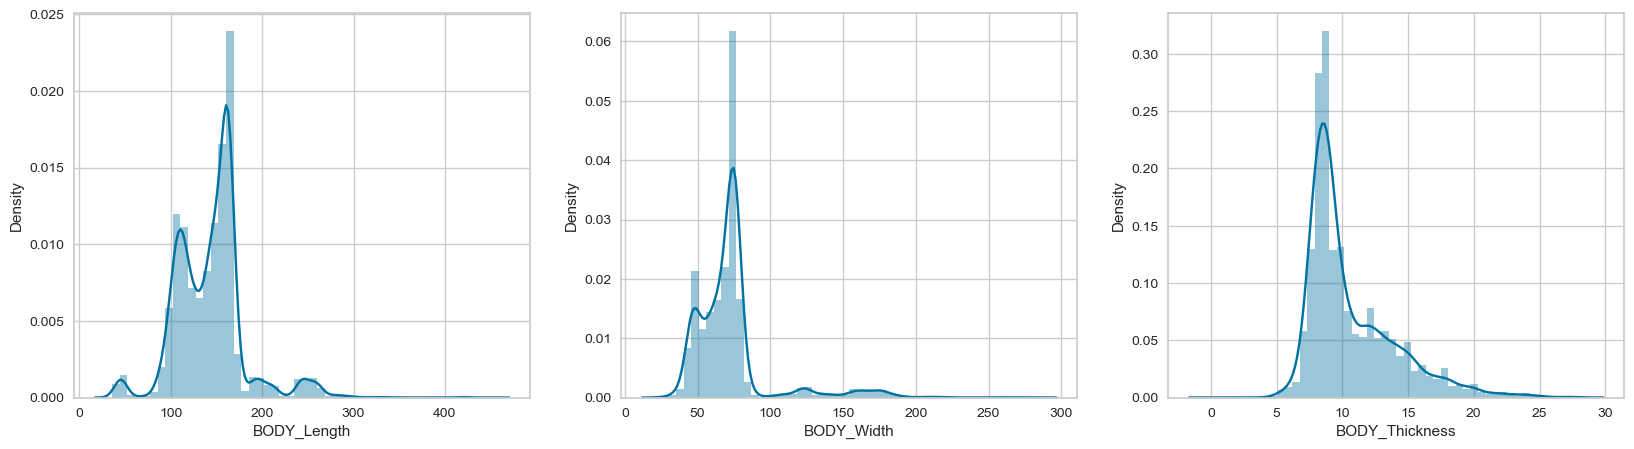

In [49]:
#plot distribution of BODY_Length, BODY_Width, BODY_Thickness to see if they are skewed
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.distplot(df.BODY_Length, ax=ax[0])
sns.distplot(df.BODY_Width, ax=ax[1])
sns.distplot(df.BODY_Thickness, ax=ax[2])


#### BODY WEIGHT:

In [50]:
df.BODY_Weight.head(10)

0      544.3 g (1.20 lb)
1        260 g (9.17 oz)
2        169 g (5.96 oz)
3        126 g (4.44 oz)
4                      -
5        166 g (5.86 oz)
7                      -
8        125 g (4.41 oz)
9     353.8 g (12.49 oz)
10       150 g (5.29 oz)
Name: BODY_Weight, dtype: object

#### BODY BUILD:

## testing w/ models

In [51]:
#print corr of each feature with price
corr = df.corr()
corr.style.background_gradient(cmap='bwr')

,Brand,NETWORK_Technology,NETWORK_2G_bands,NETWORK_3G_bands,NETWORK_4G_bands,NETWORK_5G_bands,NETWORK_GPRS,NETWORK_EDGE,NETWORK_Speed,MAIN_CAM_1_Module,SELFIE_CAM_2_Module,MISC_Price_Euro,BODY_Length,BODY_Width,BODY_Thickness
Brand,1.000000,0.123403,0.195092,0.178508,0.380628,0.018781,0.089853,0.097403,0.121147,-0.005372,0.127983,0.326875,0.068914,0.023125,-0.156191
NETWORK_Technology,0.123403,1.000000,0.476981,0.411237,0.319946,0.193865,0.483393,0.481097,0.698311,0.150030,0.610397,0.148974,0.478365,0.322816,-0.576712
NETWORK_2G_bands,0.195092,0.476981,1.000000,0.365154,0.210500,0.168442,0.383003,0.338656,0.345366,0.237853,0.476266,0.121008,0.329032,0.132606,-0.456354
NETWORK_3G_bands,0.178508,0.411237,0.365154,1.000000,0.236870,0.182334,0.523772,0.515285,0.323133,0.208642,0.465202,0.138821,0.263019,0.164716,-0.399586
NETWORK_4G_bands,0.380628,0.319946,0.210500,0.236870,1.000000,0.054801,0.140394,0.138983,0.307691,0.057563,0.193400,0.506832,0.117317,0.054552,-0.184090
NETWORK_5G_bands,0.018781,0.193865,0.168442,0.182334,0.054801,1.000000,0.097376,0.098626,0.112593,0.052641,0.137267,0.085136,0.147976,0.110957,-0.144327
NETWORK_GPRS,0.089853,0.483393,0.383003,0.523772,0.140394,0.097376,1.000000,0.888601,0.355859,0.258814,0.577342,0.069906,0.299851,0.179479,-0.468816
NETWORK_EDGE,0.097403,0.481097,0.338656,0.515285,0.138983,0.098626,0.888601,1.000000,0.351431,0.219032,0.567942,0.068146,0.289217,0.173128,-0.448047
NETWORK_Speed,0.121147,0.698311,0.345366,0.323133,0.307691,0.112593,0.355859,0.351431,1.000000,0.143716,0.448498,0.198919,0.303920,0.170407,-0.425150
MAIN_CAM_1_Module,-0.005372,0.150030,0.237853,0.208642,0.057563,0.052641,0.258814,0.219032,0.143716,1.000000,0.375028,0.012576,0.349529,0.213646,-0.217136


NETWORK_GPRS + NETWORK_EDGE khá cùi pắp

Nên chia lại test và train ra 1 chỗ riêng để evaluate tốt hơn df_na (vì khi chia lại bằng hàm thì có khả năng nó eval bằng chính cái nó tự sinh <br>
dễ gây overfitting)

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [53]:
regressors = config['regressors']
#removed regressors are those not in regressors 
removed_regressors = [est[0] for est in all_estimators() if (est[0] not in regressors)]

regressor_list = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))
]

#### Train ko cần NaN (ko fill in target)

In [54]:
config['variables']

['Brand',
 'NETWORK_2G_bands',
 'NETWORK_3G_bands',
 'NETWORK_4G_bands',
 'NETWORK_5G_bands',
 'NETWORK_Speed',
 'NETWORK_Technology',
 'BODY_Length',
 'BODY_Width',
 'BODY_Thickness']

In [55]:
X = df[config['variables']]
y = df['MISC_Price_Euro']
X.head()

,Brand,NETWORK_2G_bands,NETWORK_3G_bands,NETWORK_4G_bands,NETWORK_5G_bands,NETWORK_Speed,NETWORK_Technology,BODY_Length,BODY_Width,BODY_Thickness
0,172.02,302.11,140.86,157.74,307.45,145.48,300.93,238.30,172.20,9.90
1,175.89,473.71,203.31,172.10,307.45,1089.07,504.50,191.70,101.00,9.40
2,172.02,264.91,483.19,517.84,307.45,742.83,504.50,153.80,75.60,8.50
3,173.12,264.91,483.19,517.84,307.45,389.28,504.50,145.50,72.50,8.50
4,172.02,302.11,140.86,157.74,307.45,145.48,300.93,259.00,167.00,8.90


In [56]:
scaler = StandardScaler()
X = scaler.fit_transform(X,y)
X_scaled = pd.DataFrame(X, columns=config['variables'])
X_scaled.head()

,Brand,NETWORK_2G_bands,NETWORK_3G_bands,NETWORK_4G_bands,NETWORK_5G_bands,NETWORK_Speed,NETWORK_Technology,BODY_Length,BODY_Width,BODY_Thickness
0,-0.43,-0.21,-1.29,-0.34,-0.23,-0.85,-0.15,2.50,3.68,-0.22
1,-0.42,1.14,-0.87,-0.31,-0.23,3.77,1.10,1.27,1.05,-0.36
2,-0.43,-0.50,1.02,0.55,-0.23,2.07,1.10,0.27,0.11,-0.63
3,-0.43,-0.50,1.02,0.55,-0.23,0.34,1.10,0.05,-0.00,-0.63
4,-0.43,-0.21,-1.29,-0.34,-0.23,-0.85,-0.15,3.05,3.49,-0.51


In [57]:
y = scaler.fit_transform(np.array(y).reshape(-1, 1))
y_scaled = pd.DataFrame(y, columns=['MISC_Price_Euro'])

In [58]:
df_scaled = pd.concat([X_scaled, y_scaled], axis=1)

chia `test` và `train` ra 2 chỗ riêng, đảm bảo khi eval thì ko bị overfitting

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=0)
#remove test set from df_scaled
df_scaled = df_scaled.drop(X_test.index)
df_scaled.shape

(5906, 11)

In [60]:
X_test.shape

(2532, 10)

In [61]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [62]:
def lazy_eval(X_train, y_train, X_test, y_test):
    reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None,predictions=True, regressors = regressor_list)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    return models, predictions

In [63]:
models, predictions = lazy_eval(X_train, y_train, X_test, y_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [64]:
# models, predictions = lazy_eval(df, config['variables'], 'MISC_Price_Euro', config['test_size'], 0)
# this is for the case when we don't scale the data

In [65]:
predictions.head()

,DecisionTreeRegressor,ElasticNet,ExtraTreesRegressor,GradientBoostingRegressor,KNeighborsRegressor,Lasso,LinearRegression,RandomForestRegressor,Ridge,SGDRegressor
0,-0.15,0.00,-0.08,-0.15,-0.13,0.00,-0.02,-0.12,-0.02,-0.03
1,-0.19,-0.00,-0.21,-0.18,-0.23,0.00,-0.24,-0.22,-0.24,-0.24
2,-0.15,-0.00,-0.11,-0.16,-0.12,0.00,-0.23,-0.12,-0.23,-0.24
3,-0.19,0.01,-0.19,-0.29,-0.22,0.00,0.32,-0.20,0.32,0.31
4,0.55,0.00,0.47,0.25,0.07,0.00,0.01,0.32,0.01,-0.00


In [66]:
# metrics = {}

# for model in predictions.columns:
#     mse = mean_squared_error(y_test, predictions[model])
#     rmse = mean_squared_error(y_test, predictions[model], squared=False)
#     r2 = r2_score(y_test, predictions[model])
    
#     metrics[model] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}

# # Convert the metrics dictionary to a DataFrame
# predictions_eval = pd.DataFrame(metrics).T
# predictions_eval.sort_values(by='R2', ascending=False, inplace=True)
# predictions_eval

In [67]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.45,0.46,0.70,0.97
KNeighborsRegressor,0.40,0.40,0.73,0.11
RandomForestRegressor,0.38,0.38,0.75,5.90
ExtraTreesRegressor,0.36,0.36,0.76,2.70
SGDRegressor,0.28,0.29,0.80,0.02
Ridge,0.28,0.28,0.81,0.01
LinearRegression,0.28,0.28,0.81,0.02
ElasticNet,0.01,0.01,0.95,0.02
Lasso,-0.00,-0.00,0.95,0.01


In [68]:
def target_fill_with_retrain(df, model, variables, target):
    X = df_scaled[variables]
    y = df_scaled[target]
    model.fit(X, y)
    X_na = df_na[variables]
    y_na = model.predict(X_na)
    df_na[target] = y_na
    df = df.append(df_na)
    return df

model = GradientBoostingRegressor()
df = target_fill_with_retrain(df_scaled, model, config['fillna_retrain_variables'], config['target'])
df.shape

(9980, 53)

#### re-train and testing with lazy predict (sau khi fill-in target và evaluate lại)

In [69]:
models_retrain, predictions_retrain = lazy_eval(df[config['variables']], df['MISC_Price_Euro'], X_test, y_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.38,0.39,0.75,1.25
ExtraTreesRegressor,0.37,0.38,0.75,2.73
RandomForestRegressor,0.34,0.34,0.77,6.84
LinearRegression,0.01,0.01,0.95,0.02
Ridge,0.01,0.01,0.95,0.02
SGDRegressor,0.01,0.01,0.95,0.02
KNeighborsRegressor,-0.02,-0.01,0.96,0.05
DecisionTreeRegressor,-0.16,-0.15,1.02,0.12
Lasso,-0.78,-0.77,1.27,0.01


In [70]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from yellowbrick.regressor import ResidualsPlot

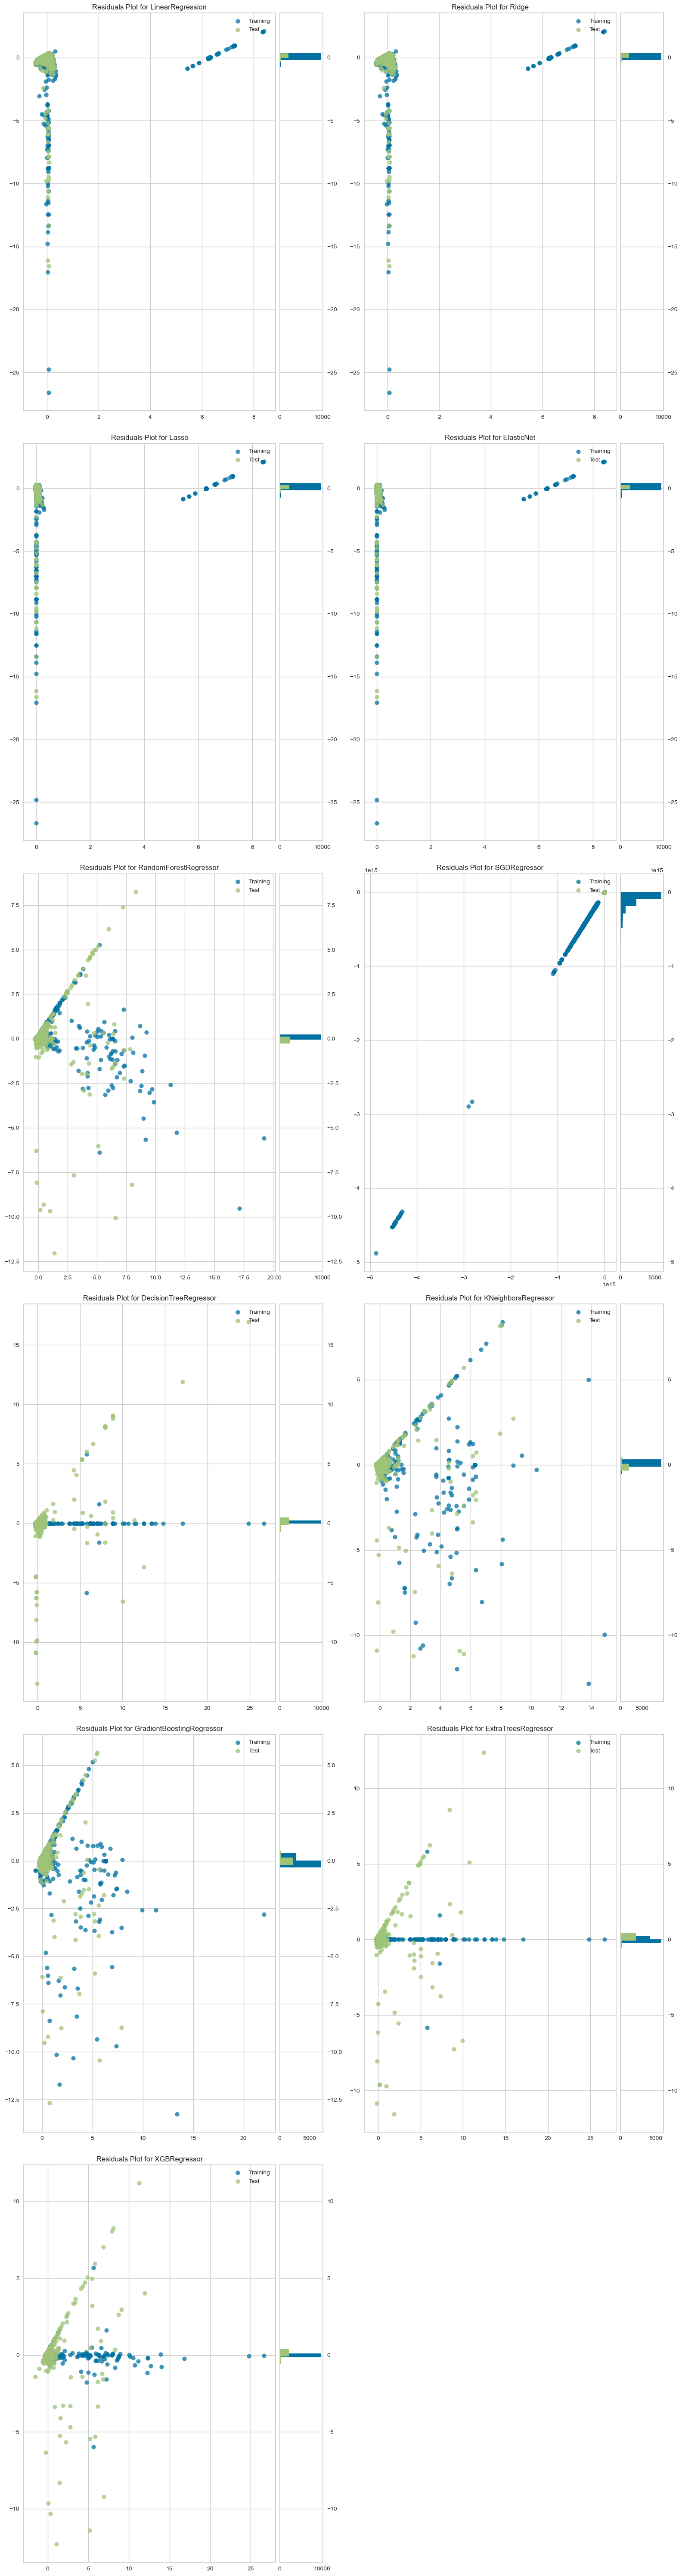

In [84]:
n = len(config['regressors'])
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(16, 10*nrows))

# Flatten the 2D array to 1D for easier looping
axs = axs.flatten()

for ax, Regressor in zip(axs, config['regressors']):
    # Create an instance of the regressor
    model = eval(Regressor)()  # Convert the string to an actual regressor object
    
    # Fit the model with the training data
    model.fit(df[config['variables']], df['MISC_Price_Euro'])
    
    # Create the ResidualsPlot with the model
    visualizer = ResidualsPlot(model, ax=ax)
    
    # Fit the visualizer with the training data
    visualizer.fit(df[config['variables']], df['MISC_Price_Euro'])
    
    # Score the visualizer with the test data
    visualizer.score(X_test, y_test)
    
    # Add a title to the plot
    visualizer.set_title(f'Residuals Plot for {Regressor}')
    
    # Add a custom legend
    ax.legend(["Training", "Test"], loc='upper right')

# Remove empty subplots
if n % ncols != 0:
    for ax in axs[n:]:
        fig.delaxes(ax)

# Show the plot
plt.tight_layout()
plt.show()

In [77]:
models_retrain

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.38,0.39,0.75,1.25
ExtraTreesRegressor,0.37,0.38,0.75,2.73
RandomForestRegressor,0.34,0.34,0.77,6.84
LinearRegression,0.01,0.01,0.95,0.02
Ridge,0.01,0.01,0.95,0.02
SGDRegressor,0.01,0.01,0.95,0.02
KNeighborsRegressor,-0.02,-0.01,0.96,0.05
DecisionTreeRegressor,-0.16,-0.15,1.02,0.12
Lasso,-0.78,-0.77,1.27,0.01


In [75]:
predictions_retrain.head()

,DecisionTreeRegressor,ElasticNet,ExtraTreesRegressor,GradientBoostingRegressor,KNeighborsRegressor,Lasso,LinearRegression,RandomForestRegressor,Ridge,SGDRegressor
0,-0.15,0.94,-0.08,-0.14,-0.18,0.83,0.02,-0.12,0.02,0.02
1,-0.19,0.94,-0.21,-0.19,-0.19,0.83,-0.18,-0.22,-0.18,-0.19
2,-0.15,0.94,-0.12,-0.16,-0.12,0.83,0.01,-0.12,0.01,0.00
3,-0.19,0.95,-0.19,-0.33,-0.22,0.83,0.04,-0.20,0.04,0.04
4,0.55,0.95,0.58,0.30,-0.00,0.83,0.07,0.27,0.07,0.07


In [76]:
df.to_csv(os.path.join(config['SavePath'], config['files'] + "_preprocessed.csv"), index=False)

**Nhận xét sau khi fillin = regressor**:
- `một vài regressor không hoạt động` lasso, elasticnet, ridge thì chắc do implement (bỏ khỏi regressors), sgd nhìn chung do outlier, nhìn thì thấp nhưng mà một vài outlier khiến mean tụt xuống (chọn lại features)
- `một vài regressor hoạt động tốt` nhưng mà `mean` của nó thấp hơn so với `mean` của `train` (có thể do `train` có nhiều outlier hơn `test`)
- `đọc lại plot thấy cần edit lại nhận xét hmm` 